Unbalanced classification problems cause problems to many learning algorithms. These problems are characterized by the uneven proportion of cases that are available for each class of the problem.


Most classification algorithms will only perform optimally when the number of samples of each class is roughly the same. Highly skewed datasets, where the minority heavily outnumbered by one or more classes, haven proven to be a challenge while at the same time becoming more and more common.

One way of addresing this issue is by resampling the dataset as to offset this imbalance with the hope of arriving and a more robust and fair decision boundary than you would otherwise.

Resampling techniques are divided in two categories:

- Under-sampling the majority class(es)
- Over-sampling the minority class

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
plt.style.use('ggplot')

In [5]:
# Generate some data
X, y= make_classification(n_classes=2, class_sep=2, weights=[0.9,0.1], n_informative=3, n_redundant=1, flip_y=0, n_features=20, 
                          n_clusters_per_class=1, n_samples=1000, random_state=10)

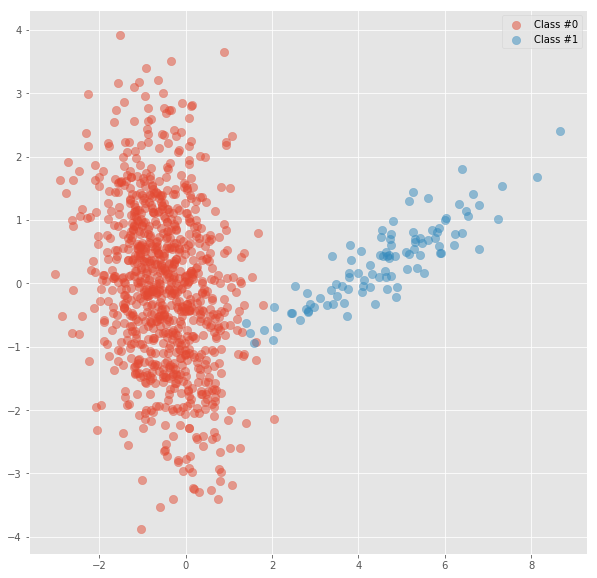

In [6]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X)

# Plot the original data

def plot_two_classes(X, y, subplot=False, size=(10, 10)):
    # Plot the two classes
    if subplot == False:
        fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=size)
        
    subplot.scatter(X[y==0, 0], X[y==0, 1], label="Class #0", 
                    alpha=0.5, s=70)
    subplot.scatter(X[y==1, 0], X[y==1, 1], label="Class #1", 
                    alpha=0.5, s=70)
    subplot.legend()
    return subplot

plot_two_classes(x_vis, y)

In [7]:
y.mean()

0.10000000000000001

# Part 1: Under-sampling

## Random - Under-sampling

Randomly select a percentage of the negative class such that the resulting dataset is balanced

In [8]:
n_samples=y.shape[0]
print(n_samples)

1000


In [9]:
n_samples_0=(y==0).sum()
print(n_samples_0)

900


In [10]:
n_samples_1=(y==1).sum()
print(n_samples_1)

100


In [11]:
n_samples_1/n_samples

0.10000000000000001

How many negatives cases should I select if I want a new dataset with 50% of positives?

0.5 = n_samples_1 / (n_samples_1 + n_samples_0_new)

(n_samples_1 + n_samples_0_new) = n_samples_1 / 0.5

In [12]:
n_samples_0_new=n_samples_1/0.5-n_samples_1
n_samples_0_new

100.0

In [13]:
n_samples_0_new_per=n_samples_0_new / n_samples_0
n_samples_0_new_per

0.1111111111111111

Create a filter to select n_samples_0_new_per from the negative class

In [14]:
# Select all negatives
filter_=y==0
# Random sample
np.random.seed(42)
rand_1=np.random.binomial(n=1, p=n_samples_0_new_per,size=n_samples)
# Combine
filter_ = filter_ & rand_1

In [15]:
filter_.sum()

108


Also select all the positives

In [16]:
filter_ = filter_ | (y == 1)

In [17]:
filter_ = filter_.astype(bool)

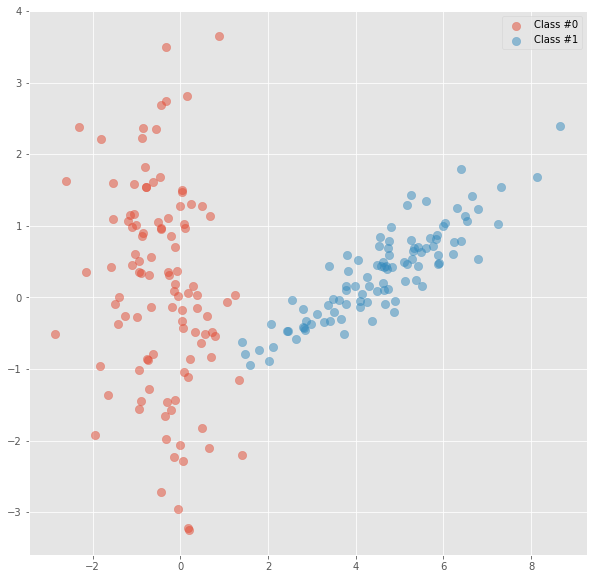

In [18]:
plot_two_classes(x_vis[filter_], y[filter_])

Convert into a function

In [19]:
def UnderSampling(X, y, target_percentage=0.5, seed=None):
    # Assuming minority class is the positive
    n_samples=y.shape[0]
    n_samples_0 = (y == 0).sum()
    n_samples_1 = (y == 1).sum()
    n_samples_0_new =  n_samples_1 / target_percentage - n_samples_1
    n_samples_0_new_per = n_samples_0_new / n_samples_0

    filter_ = y == 0
    np.random.seed(seed)
    rand_1 = np.random.binomial(n=1, p=n_samples_0_new_per, size=n_samples)
    
    filter_ = filter_ & rand_1
    filter_ = filter_ | (y == 1)
    filter_ = filter_.astype(bool)
    
    return X[filter_], y[filter_]

Target percentage 0.1
y.shape =  1000 y.mean() =  0.1


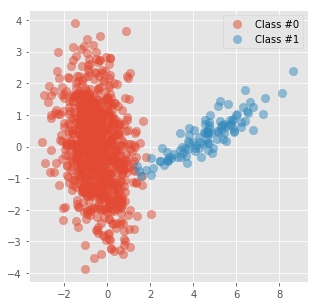

Target percentage 0.2
y.shape =  510 y.mean() =  0.196078431373


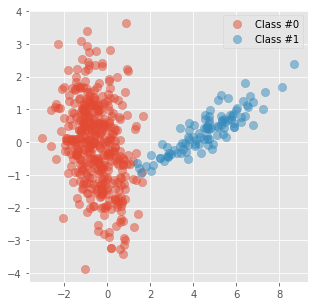

Target percentage 0.3
y.shape =  343 y.mean() =  0.291545189504


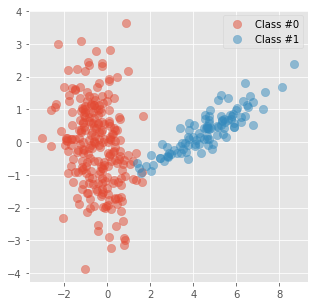

Target percentage 0.4
y.shape =  249 y.mean() =  0.401606425703


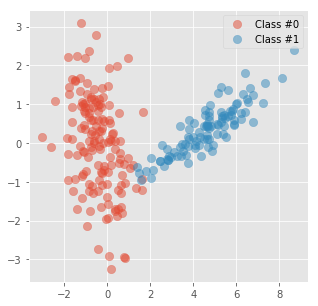

Target percentage 0.5
y.shape =  199 y.mean() =  0.502512562814


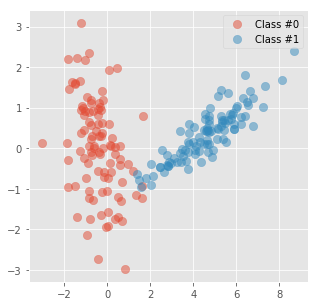

In [20]:
for target_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
    X_u, y_u=UnderSampling(x_vis, y, target_percentage, 1)
    print('Target percentage', target_percentage)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()

Comparing Under-Sampling with other model

__Advantages of Under-Sampling:__

- Fast to estimate
- Easy to understand

__Disadvantages of Under-Sampling:__

- Information of the negative class is lost
- Variance due to randomnes
- Need to define the target percentage

__TomekLinks__

Identify and remove majority samples that form a Tomek link with minority samples.

Find the nearest neighbour of every point

In [21]:
from sklearn.neighbors import NearestNeighbors
nn=NearestNeighbors(n_neighbors=2)
nn.fit(x_vis)
nns = nn.kneighbors(x_vis, return_distance=False)[:, 1]

In [22]:
nns[0:10]

array([750, 843, 103, 366, 165, 682, 277, 606, 600, 298], dtype=int64)

Find if tomek. Use the target vector and the first neighbour of every sample point and looks for Tomek pairs. Returning a boolean vector with True for majority Tomek links.

In [23]:
# Initialize the boolean result as false, and also a counter
links = np.zeros(len(y), dtype=bool)

# Loop through each sample of the majority class then we
# look at its first neighbour. If its closest neighbour also has the
# current sample as its closest neighbour, the two form a Tomek link.
for ind, ele in enumerate(y):

    if ele == 1 | links[ind] == True:  # Keep all from the minority class
        continue

    if y[nns[ind]] == 1:

        # If they form a tomek link, put a True marker on this
        # sample, and increase counter by one.
        if nns[nns[ind]] == ind:
            links[ind] = True

In [24]:
links.sum()

2

In [25]:
filter_ = np.logical_not(links)

y.shape =  998 y.mean() =  0.100200400802


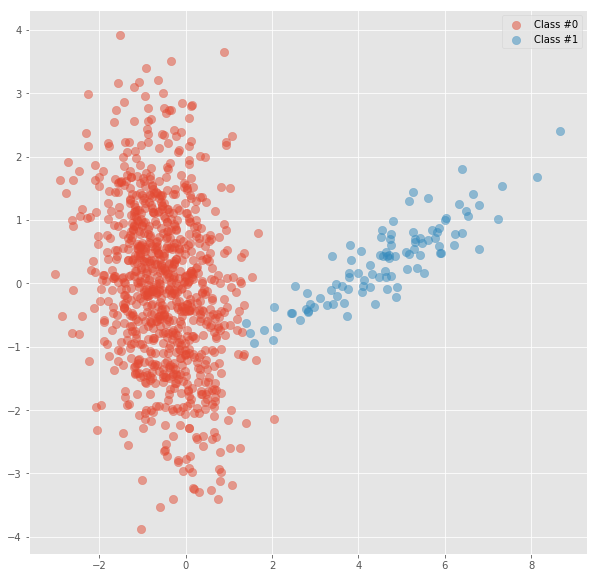

In [26]:

print('y.shape = ',y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

## Comparing TomekLinks with other models

### Advantages of TomekLinks:

- Creates a linearly-separable space

### Disadvantages of TomekLinks:

- Still a highly imbalance dataset

## Condensed Nearest Neighbour

The goal is to eliminate examples from the majority class that are much further away from the border

In [27]:
# Import the K-NN classifier
from sklearn.neighbors import KNeighborsClassifier


In [47]:
# Number of samples to extract in order to build the set S.
n_seeds_S=51
# Size of the neighbourhood to consider to compute the
# average distance to the minority point samples.
size_ngh=100
# Randomly get one sample from the majority class
np.random.seed(42)
maj_sample=np.random.choice(x_vis[y==0].shape[0],n_seeds_S)
maj_sample=x_vis[y==0][maj_sample]

In [48]:
# Create the set C
# Select all positive and the randomly selected negatives
C_x = np.append(x_vis[y == 1], maj_sample, axis=0)
C_y = np.append(y[y == 1], [0] * n_seeds_S)

In [49]:
# Create the set S
S_x=x_vis[y==0]
S_y=y[y==0]

In [50]:
knn=KNeighborsClassifier(n_neighbors=size_ngh)
# Fit C into the knn
knn.fit(C_x,C_y)
# Classify on S
pred_S_y= knn.predict(S_x)

In [51]:
# Find the misclassified S_y
idx_tmp=np.nonzero(y==0)[0][np.nonzero(pred_S_y!=S_y)]

In [52]:
filter_ = np.nonzero(y == 1)[0]
filter_ = np.concatenate((filter_, idx_tmp), axis=0)

y.shape= 163 y.mean() =  0.613496932515


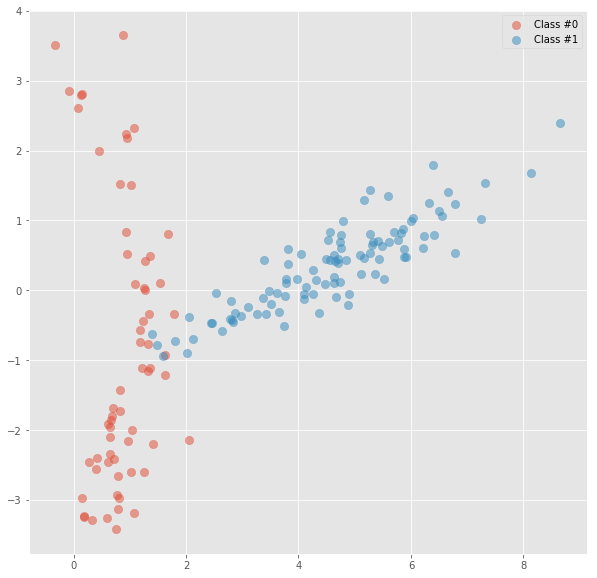

In [53]:
print('y.shape=', y[filter_].shape[0], 'y.mean() = ', y[filter_].mean())
plot_two_classes(x_vis[filter_], y[filter_])

In [56]:
# Import the K-NN classifier
from sklearn.neighbors import KNeighborsClassifier
def CondensedNearestNeighbor(X, y, n_seeds_S=1, size_ngh=1, seed=None):
    # Randomly get one sample from the majority class
    np.random.seed(seed)
    maj_sample = np.random.choice(X[y == 0].shape[0], n_seeds_S)
    maj_sample = X[y == 0][maj_sample]
    # Create the set C
    # Select all positive and the randomly selected negatives
    C_x = np.append(X[y == 1], maj_sample, axis=0)
    C_y = np.append(y[y == 1], [0] * n_seeds_S)
    # Create the set S
    S_x = X[y == 0]
    S_y = y[y == 0]
    knn = KNeighborsClassifier(n_neighbors=size_ngh)

    # Fit C into the knn
    knn.fit(C_x, C_y)

    # Classify on S
    pred_S_y = knn.predict(S_x)
    # Find the misclassified S_y
    idx_tmp = np.nonzero(y == 0)[0][np.nonzero(pred_S_y != S_y)]

    filter_ = np.nonzero(y == 1)[0]
    filter_ = np.concatenate((filter_, idx_tmp), axis=0)

    return X[filter_], y[filter_]

n_seeds_S  51 size_ngh  1
y.shape =  384 y.mean() =  0.260416666667


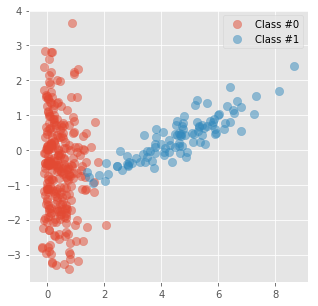

n_seeds_S  51 size_ngh  100
y.shape =  100 y.mean() =  1.0


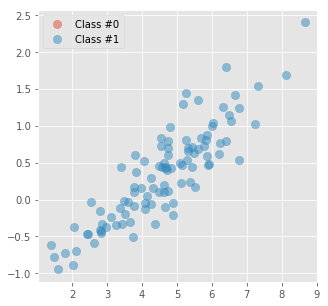

n_seeds_S  51 size_ngh  50
y.shape =  110 y.mean() =  0.909090909091


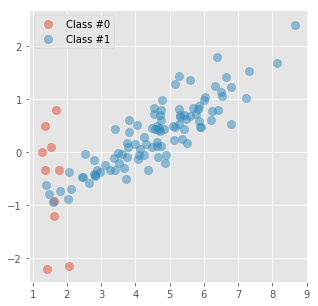

n_seeds_S  51 size_ngh  50
y.shape =  102 y.mean() =  0.980392156863


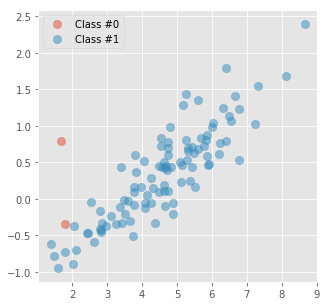

n_seeds_S  51 size_ngh  100
y.shape =  248 y.mean() =  0.403225806452


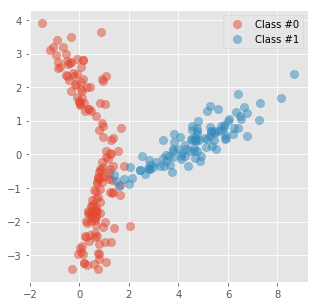

In [57]:
for n_seed_S, size_ngh in [(1, 1), (100, 100), (50, 50), (100, 50), (50, 100)]:
    X_u,y_u=CondensedNearestNeighbor(x_vis,y,n_seed_S, size_ngh,1)
    print('n_seeds_S ', n_seeds_S, 'size_ngh ', size_ngh)
    print('y.shape = ',y_u.shape[0], 'y.mean() = ', y_u.mean())
    plot_two_classes(X_u, y_u, size=(5, 5))
    plt.show()

## Other Under-sampling methods
- Under-sampling with Cluster Centroids
- NearMiss-(1 & 2 & 3)
- One-Sided Selection
- Neighboorhood Cleaning Rule

# Over-Sampling